In [91]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
import numpy as np
import json
import csv


In [92]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
# desired_res = (32, 32, 32)

In [93]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.train()  # Set the model to training mode

# Define hyperparameters for fine-tuning
fine_tune_hyperparams = {
    'learning_rate': 1e-6,  # Small learning rate
    'batch_size': 16,       # Smaller batch size for limited data
    'num_epochs': 150,
    'factor': 0.5,          # LR decay factor
    'patience': 3           # Patience for LR scheduler
}
print(desired_res)

(32, 32, 32)


In [94]:
foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}
for i, knot in enumerate(knots):
    print(knot, ':  ', i)

0000 :   0
0001 :   1
0002 :   2
0010 :   3
0011 :   4
0012 :   5
0020 :   6
0021 :   7
0022 :   8
0100 :   9
0101 :   10
0102 :   11
0110 :   12
0111 :   13
0112 :   14
0120 :   15
0121 :   16
0122 :   17
0200 :   18
0201 :   19
0202 :   20
0210 :   21
0211 :   22
0212 :   23
0220 :   24
0221 :   25
0222 :   26
1000 :   27
1001 :   28
1002 :   29
1010 :   30
1011 :   31
1012 :   32
1020 :   33
1021 :   34
1022 :   35
1100 :   36
1101 :   37
1102 :   38
1110 :   39
1111 :   40
1112 :   41
1120 :   42
1121 :   43
1122 :   44
1200 :   45
1201 :   46
1202 :   47
1210 :   48
1211 :   49
1212 :   50
1220 :   51
1221 :   52
1222 :   53
2000 :   54
2001 :   55
2002 :   56
2010 :   57
2011 :   58
2012 :   59
2020 :   60
2021 :   61
2022 :   62
2100 :   63
2101 :   64
2102 :   65
2110 :   66
2111 :   67
2112 :   68
2120 :   69
2121 :   70
2122 :   71
2200 :   72
2201 :   73
2202 :   74
2210 :   75
2211 :   76
2212 :   77
2220 :   78
2221 :   79
2222 :   80


In [95]:

folders = [
    # '/home/dt169/ML_knots/DATA/all_flowers10_5.4/',
    'C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\\all_flowers10_4.6',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_experiment_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')




File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0000.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0001.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0002.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0010.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0011.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0012.csv
File not found: C:\SCIENCE\programming\Python\Turbulence\knots_propagation\Danilo_4foils_experiment\all_flowers10_4.6/data_experiment_0020.csv

In [96]:
from sklearn.model_selection import train_test_split

# Convert data lists into numpy arrays
X_np = np.array(X_list)
y_np = np.array(Y_list)

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Convert to PyTorch tensors
X_torch_train = torch.tensor(X_train).reshape(-1, 1, *desired_res).float()
X_torch_test = torch.tensor(X_test).reshape(-1, 1, *desired_res).float()
y_torch_train = torch.tensor(y_train)
y_torch_test = torch.tensor(y_test)
print()
# One-hot encode the labels
y_train_dots = F.one_hot(y_torch_train.long(), num_classes=num_classes).float()
y_test_dots = F.one_hot(y_torch_test.long(), num_classes=num_classes).float()

# Create TensorDatasets for training and testing
train_dataset_dots = TensorDataset(X_torch_train, y_train_dots)
test_dataset_dots = TensorDataset(X_torch_test, y_test_dots)

# Create DataLoaders for training and testing
train_loader_dots = DataLoader(train_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)

print(f"Training set size: {len(train_dataset_dots)}")
print(f"Testing set size: {len(test_dataset_dots)}")


Training set size: 368
Testing set size: 92


In [97]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


In [98]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


tensor([45, 47, 28, 24,  0, 27, 36,  9, 63, 48,  0,  0, 27, 35,  0, 54, 44, 63,
         0, 42,  0, 45, 27,  6,  0,  1,  0, 20, 69, 17, 26, 14, 27, 27, 45, 70,
        60,  1, 19,  7, 45, 51, 15, 48, 54, 60, 75, 27, 69, 60,  0, 69,  9,  1,
        65,  9, 62, 47, 24, 27,  3, 59, 26, 72, 44, 36, 42, 27, 52, 11, 72, 56,
        45, 63, 72, 44, 54,  0,  0, 17, 18,  0, 19,  9, 27, 57, 27, 63,  6,  0,
        54, 63, 27, 33, 23,  0, 69, 45,  8, 24, 63,  3,  9, 18, 54, 66, 38,  7,
        45, 37, 28, 15, 36, 44, 74, 28, 74,  4, 56,  9, 62, 69, 60, 27, 47,  3,
        15, 46, 72, 54,  1, 54, 48, 24, 36, 27, 62, 71, 48, 44, 27, 72, 48,  9,
        48, 56,  1, 71, 62, 53, 54,  0,  3, 48, 74, 18, 21,  1, 66, 35, 64, 56,
        46, 47, 20, 27, 27, 63, 45, 64, 45,  3, 15,  0, 19, 17, 27,  2, 54, 73,
        27, 11, 27, 27, 36,  6,  0,  0, 20,  9,  9, 69, 45, 74, 54,  0, 60, 24,
        75, 47, 54, 46, 74, 44,  0, 55, 63, 57, 63,  0, 54, 20, 51, 18, 51,  0,
         9,  6, 27, 30, 45, 46, 51, 69, 

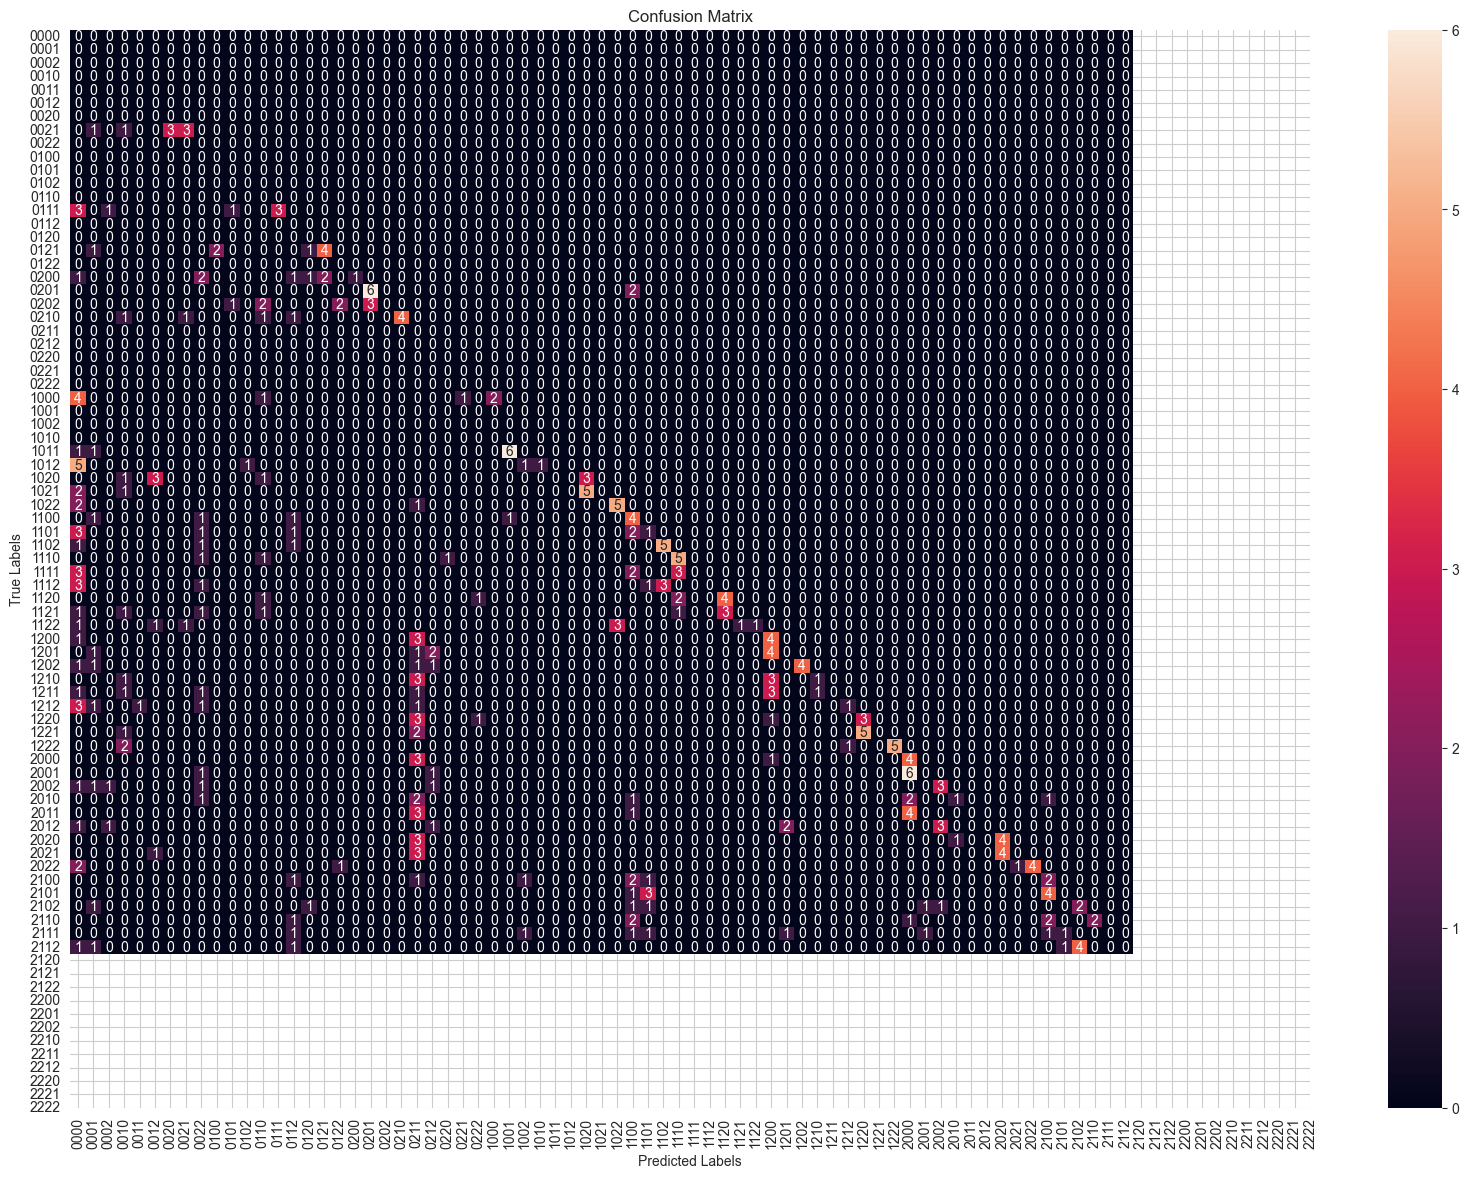

0.24728260869565216


In [99]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in train_loader_dots:
        inputs = batch[0].to(device)
        # print(torch.max(batch[1], 1)[1])
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
print(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_train_dots, 1)
print(true_class_labels)
# print(torch.max(y_test_dots, 1)[1])
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

In [105]:

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=fine_tune_hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=fine_tune_hyperparams['factor'],
                              patience=fine_tune_hyperparams['patience'], verbose=True)

# Mixed precision training setup
scaler = GradScaler()

# Fine-tuning loop
train_losses = []
for epoch in trange(fine_tune_hyperparams['num_epochs'], desc="Fine-tuning Progress"):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader_dots:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():  # Enable mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backpropagation with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader_dots)
    train_losses.append(avg_loss)

    # Step the LR scheduler
    scheduler.step(avg_loss)

    print(f"Epoch {epoch + 1}/{fine_tune_hyperparams['num_epochs']}, Loss: {avg_loss:.4f}")

# Save the fine-tuned model
fine_tuned_model_path = "fine_tuned_classifier_4foil_3d.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': fine_tune_hyperparams,
    'stages': stages,
    'pooling_configs': pooling_configs,
    'desired_res': desired_res,
    'num_classes': num_classes
}, fine_tuned_model_path)

print(f"Fine-tuned model saved to {fine_tuned_model_path}")

Fine-tuning Progress:   1%|          | 1/150 [00:00<02:21,  1.05it/s]

Epoch 1/150, Loss: 0.3835


Fine-tuning Progress:   1%|▏         | 2/150 [00:01<01:56,  1.27it/s]

Epoch 2/150, Loss: 0.3768


Fine-tuning Progress:   2%|▏         | 3/150 [00:02<01:48,  1.36it/s]

Epoch 3/150, Loss: 0.3710


Fine-tuning Progress:   3%|▎         | 4/150 [00:02<01:43,  1.41it/s]

Epoch 4/150, Loss: 0.3661


Fine-tuning Progress:   3%|▎         | 5/150 [00:03<01:41,  1.44it/s]

Epoch 5/150, Loss: 0.3612


Fine-tuning Progress:   4%|▍         | 6/150 [00:04<01:38,  1.46it/s]

Epoch 6/150, Loss: 0.3565


Fine-tuning Progress:   5%|▍         | 7/150 [00:04<01:37,  1.47it/s]

Epoch 7/150, Loss: 0.3519


Fine-tuning Progress:   5%|▌         | 8/150 [00:05<01:35,  1.48it/s]

Epoch 8/150, Loss: 0.3475


Fine-tuning Progress:   6%|▌         | 9/150 [00:06<01:35,  1.48it/s]

Epoch 9/150, Loss: 0.3432


Fine-tuning Progress:   7%|▋         | 10/150 [00:07<01:35,  1.47it/s]

Epoch 10/150, Loss: 0.3390


Fine-tuning Progress:   7%|▋         | 11/150 [00:07<01:36,  1.44it/s]

Epoch 11/150, Loss: 0.3349


Fine-tuning Progress:   8%|▊         | 12/150 [00:08<01:35,  1.45it/s]

Epoch 12/150, Loss: 0.3308


Fine-tuning Progress:   9%|▊         | 13/150 [00:09<01:33,  1.47it/s]

Epoch 13/150, Loss: 0.3268


Fine-tuning Progress:   9%|▉         | 14/150 [00:09<01:32,  1.47it/s]

Epoch 14/150, Loss: 0.3229


Fine-tuning Progress:  10%|█         | 15/150 [00:10<01:31,  1.47it/s]

Epoch 15/150, Loss: 0.3192


Fine-tuning Progress:  11%|█         | 16/150 [00:11<01:31,  1.47it/s]

Epoch 16/150, Loss: 0.3155


Fine-tuning Progress:  11%|█▏        | 17/150 [00:11<01:30,  1.47it/s]

Epoch 17/150, Loss: 0.3118


Fine-tuning Progress:  12%|█▏        | 18/150 [00:12<01:29,  1.48it/s]

Epoch 18/150, Loss: 0.3082


Fine-tuning Progress:  13%|█▎        | 19/150 [00:13<01:28,  1.48it/s]

Epoch 19/150, Loss: 0.3048


Fine-tuning Progress:  13%|█▎        | 20/150 [00:13<01:27,  1.49it/s]

Epoch 20/150, Loss: 0.3013


Fine-tuning Progress:  14%|█▍        | 21/150 [00:14<01:26,  1.49it/s]

Epoch 21/150, Loss: 0.2979


Fine-tuning Progress:  15%|█▍        | 22/150 [00:15<01:26,  1.49it/s]

Epoch 22/150, Loss: 0.2946


Fine-tuning Progress:  15%|█▌        | 23/150 [00:15<01:25,  1.49it/s]

Epoch 23/150, Loss: 0.2914


Fine-tuning Progress:  16%|█▌        | 24/150 [00:16<01:24,  1.49it/s]

Epoch 24/150, Loss: 0.2882


Fine-tuning Progress:  17%|█▋        | 25/150 [00:17<01:24,  1.49it/s]

Epoch 25/150, Loss: 0.2850


Fine-tuning Progress:  17%|█▋        | 26/150 [00:17<01:23,  1.49it/s]

Epoch 26/150, Loss: 0.2820


Fine-tuning Progress:  18%|█▊        | 27/150 [00:18<01:22,  1.49it/s]

Epoch 27/150, Loss: 0.2789


Fine-tuning Progress:  19%|█▊        | 28/150 [00:19<01:21,  1.49it/s]

Epoch 28/150, Loss: 0.2760


Fine-tuning Progress:  19%|█▉        | 29/150 [00:19<01:21,  1.49it/s]

Epoch 29/150, Loss: 0.2731


Fine-tuning Progress:  20%|██        | 30/150 [00:20<01:20,  1.49it/s]

Epoch 30/150, Loss: 0.2702


Fine-tuning Progress:  21%|██        | 31/150 [00:21<01:19,  1.49it/s]

Epoch 31/150, Loss: 0.2674


Fine-tuning Progress:  21%|██▏       | 32/150 [00:21<01:18,  1.49it/s]

Epoch 32/150, Loss: 0.2646


Fine-tuning Progress:  22%|██▏       | 33/150 [00:22<01:18,  1.49it/s]

Epoch 33/150, Loss: 0.2619


Fine-tuning Progress:  23%|██▎       | 34/150 [00:23<01:17,  1.49it/s]

Epoch 34/150, Loss: 0.2592


Fine-tuning Progress:  23%|██▎       | 35/150 [00:23<01:17,  1.49it/s]

Epoch 35/150, Loss: 0.2566


Fine-tuning Progress:  24%|██▍       | 36/150 [00:24<01:16,  1.49it/s]

Epoch 36/150, Loss: 0.2540


Fine-tuning Progress:  25%|██▍       | 37/150 [00:25<01:15,  1.49it/s]

Epoch 37/150, Loss: 0.2515


Fine-tuning Progress:  25%|██▌       | 38/150 [00:25<01:15,  1.49it/s]

Epoch 38/150, Loss: 0.2489


Fine-tuning Progress:  26%|██▌       | 39/150 [00:26<01:14,  1.49it/s]

Epoch 39/150, Loss: 0.2465


Fine-tuning Progress:  27%|██▋       | 40/150 [00:27<01:13,  1.50it/s]

Epoch 40/150, Loss: 0.2441


Fine-tuning Progress:  27%|██▋       | 41/150 [00:27<01:12,  1.50it/s]

Epoch 41/150, Loss: 0.2417


Fine-tuning Progress:  28%|██▊       | 42/150 [00:28<01:12,  1.50it/s]

Epoch 42/150, Loss: 0.2393


Fine-tuning Progress:  29%|██▊       | 43/150 [00:29<01:11,  1.50it/s]

Epoch 43/150, Loss: 0.2370


Fine-tuning Progress:  29%|██▉       | 44/150 [00:29<01:10,  1.49it/s]

Epoch 44/150, Loss: 0.2348


Fine-tuning Progress:  30%|███       | 45/150 [00:30<01:10,  1.50it/s]

Epoch 45/150, Loss: 0.2325


Fine-tuning Progress:  31%|███       | 46/150 [00:31<01:09,  1.50it/s]

Epoch 46/150, Loss: 0.2303


Fine-tuning Progress:  31%|███▏      | 47/150 [00:31<01:08,  1.50it/s]

Epoch 47/150, Loss: 0.2281


Fine-tuning Progress:  32%|███▏      | 48/150 [00:32<01:08,  1.50it/s]

Epoch 48/150, Loss: 0.2260


Fine-tuning Progress:  33%|███▎      | 49/150 [00:33<01:07,  1.50it/s]

Epoch 49/150, Loss: 0.2238


Fine-tuning Progress:  33%|███▎      | 50/150 [00:33<01:06,  1.50it/s]

Epoch 50/150, Loss: 0.2218


Fine-tuning Progress:  34%|███▍      | 51/150 [00:34<01:05,  1.50it/s]

Epoch 51/150, Loss: 0.2197


Fine-tuning Progress:  35%|███▍      | 52/150 [00:35<01:05,  1.50it/s]

Epoch 52/150, Loss: 0.2177


Fine-tuning Progress:  35%|███▌      | 53/150 [00:35<01:04,  1.50it/s]

Epoch 53/150, Loss: 0.2156


Fine-tuning Progress:  36%|███▌      | 54/150 [00:36<01:04,  1.50it/s]

Epoch 54/150, Loss: 0.2137


Fine-tuning Progress:  37%|███▋      | 55/150 [00:37<01:03,  1.50it/s]

Epoch 55/150, Loss: 0.2118


Fine-tuning Progress:  37%|███▋      | 56/150 [00:37<01:02,  1.50it/s]

Epoch 56/150, Loss: 0.2098


Fine-tuning Progress:  38%|███▊      | 57/150 [00:38<01:02,  1.50it/s]

Epoch 57/150, Loss: 0.2079


Fine-tuning Progress:  39%|███▊      | 58/150 [00:39<01:01,  1.50it/s]

Epoch 58/150, Loss: 0.2061


Fine-tuning Progress:  39%|███▉      | 59/150 [00:39<01:00,  1.50it/s]

Epoch 59/150, Loss: 0.2042


Fine-tuning Progress:  40%|████      | 60/150 [00:40<01:00,  1.49it/s]

Epoch 60/150, Loss: 0.2024


Fine-tuning Progress:  41%|████      | 61/150 [00:41<00:59,  1.50it/s]

Epoch 61/150, Loss: 0.2006


Fine-tuning Progress:  41%|████▏     | 62/150 [00:41<00:58,  1.50it/s]

Epoch 62/150, Loss: 0.1988


Fine-tuning Progress:  42%|████▏     | 63/150 [00:42<00:58,  1.49it/s]

Epoch 63/150, Loss: 0.1971


Fine-tuning Progress:  43%|████▎     | 64/150 [00:43<00:57,  1.49it/s]

Epoch 64/150, Loss: 0.1954


Fine-tuning Progress:  43%|████▎     | 65/150 [00:43<00:57,  1.48it/s]

Epoch 65/150, Loss: 0.1937


Fine-tuning Progress:  44%|████▍     | 66/150 [00:44<00:56,  1.49it/s]

Epoch 66/150, Loss: 0.1920


Fine-tuning Progress:  45%|████▍     | 67/150 [00:45<00:55,  1.49it/s]

Epoch 67/150, Loss: 0.1904


Fine-tuning Progress:  45%|████▌     | 68/150 [00:45<00:55,  1.49it/s]

Epoch 68/150, Loss: 0.1888


Fine-tuning Progress:  46%|████▌     | 69/150 [00:46<00:54,  1.49it/s]

Epoch 69/150, Loss: 0.1872


Fine-tuning Progress:  47%|████▋     | 70/150 [00:47<00:53,  1.49it/s]

Epoch 70/150, Loss: 0.1856


Fine-tuning Progress:  47%|████▋     | 71/150 [00:47<00:53,  1.49it/s]

Epoch 71/150, Loss: 0.1840


Fine-tuning Progress:  48%|████▊     | 72/150 [00:48<00:52,  1.49it/s]

Epoch 72/150, Loss: 0.1825


Fine-tuning Progress:  49%|████▊     | 73/150 [00:49<00:51,  1.49it/s]

Epoch 73/150, Loss: 0.1809


Fine-tuning Progress:  49%|████▉     | 74/150 [00:49<00:51,  1.48it/s]

Epoch 74/150, Loss: 0.1794


Fine-tuning Progress:  50%|█████     | 75/150 [00:50<00:50,  1.49it/s]

Epoch 75/150, Loss: 0.1780


Fine-tuning Progress:  51%|█████     | 76/150 [00:51<00:49,  1.49it/s]

Epoch 76/150, Loss: 0.1765


Fine-tuning Progress:  51%|█████▏    | 77/150 [00:51<00:48,  1.50it/s]

Epoch 77/150, Loss: 0.1750


Fine-tuning Progress:  52%|█████▏    | 78/150 [00:52<00:48,  1.49it/s]

Epoch 78/150, Loss: 0.1736


Fine-tuning Progress:  53%|█████▎    | 79/150 [00:53<00:47,  1.49it/s]

Epoch 79/150, Loss: 0.1722


Fine-tuning Progress:  53%|█████▎    | 80/150 [00:53<00:46,  1.49it/s]

Epoch 80/150, Loss: 0.1708


Fine-tuning Progress:  54%|█████▍    | 81/150 [00:54<00:46,  1.49it/s]

Epoch 81/150, Loss: 0.1694


Fine-tuning Progress:  55%|█████▍    | 82/150 [00:55<00:45,  1.49it/s]

Epoch 82/150, Loss: 0.1680


Fine-tuning Progress:  55%|█████▌    | 83/150 [00:55<00:44,  1.49it/s]

Epoch 83/150, Loss: 0.1667


Fine-tuning Progress:  56%|█████▌    | 84/150 [00:56<00:44,  1.49it/s]

Epoch 84/150, Loss: 0.1654


Fine-tuning Progress:  57%|█████▋    | 85/150 [00:57<00:43,  1.49it/s]

Epoch 85/150, Loss: 0.1640


Fine-tuning Progress:  57%|█████▋    | 86/150 [00:57<00:43,  1.48it/s]

Epoch 86/150, Loss: 0.1627


Fine-tuning Progress:  58%|█████▊    | 87/150 [00:58<00:42,  1.49it/s]

Epoch 87/150, Loss: 0.1615


Fine-tuning Progress:  59%|█████▊    | 88/150 [00:59<00:41,  1.49it/s]

Epoch 88/150, Loss: 0.1601


Fine-tuning Progress:  59%|█████▉    | 89/150 [01:00<00:40,  1.49it/s]

Epoch 89/150, Loss: 0.1589


Fine-tuning Progress:  60%|██████    | 90/150 [01:00<00:40,  1.49it/s]

Epoch 90/150, Loss: 0.1576


Fine-tuning Progress:  61%|██████    | 91/150 [01:01<00:39,  1.49it/s]

Epoch 91/150, Loss: 0.1564


Fine-tuning Progress:  61%|██████▏   | 92/150 [01:02<00:38,  1.50it/s]

Epoch 92/150, Loss: 0.1552


Fine-tuning Progress:  62%|██████▏   | 93/150 [01:02<00:38,  1.50it/s]

Epoch 93/150, Loss: 0.1540


Fine-tuning Progress:  63%|██████▎   | 94/150 [01:03<00:37,  1.50it/s]

Epoch 94/150, Loss: 0.1528


Fine-tuning Progress:  63%|██████▎   | 95/150 [01:04<00:36,  1.49it/s]

Epoch 95/150, Loss: 0.1517


Fine-tuning Progress:  64%|██████▍   | 96/150 [01:04<00:36,  1.49it/s]

Epoch 96/150, Loss: 0.1505


Fine-tuning Progress:  65%|██████▍   | 97/150 [01:05<00:35,  1.49it/s]

Epoch 97/150, Loss: 0.1493


Fine-tuning Progress:  65%|██████▌   | 98/150 [01:06<00:34,  1.49it/s]

Epoch 98/150, Loss: 0.1482


Fine-tuning Progress:  66%|██████▌   | 99/150 [01:06<00:34,  1.49it/s]

Epoch 99/150, Loss: 0.1470


Fine-tuning Progress:  67%|██████▋   | 100/150 [01:07<00:33,  1.49it/s]

Epoch 100/150, Loss: 0.1459


Fine-tuning Progress:  67%|██████▋   | 101/150 [01:08<00:32,  1.49it/s]

Epoch 101/150, Loss: 0.1448


Fine-tuning Progress:  68%|██████▊   | 102/150 [01:08<00:32,  1.49it/s]

Epoch 102/150, Loss: 0.1437


Fine-tuning Progress:  69%|██████▊   | 103/150 [01:09<00:31,  1.48it/s]

Epoch 103/150, Loss: 0.1427


Fine-tuning Progress:  69%|██████▉   | 104/150 [01:10<00:30,  1.49it/s]

Epoch 104/150, Loss: 0.1416


Fine-tuning Progress:  70%|███████   | 105/150 [01:10<00:30,  1.48it/s]

Epoch 105/150, Loss: 0.1406


Fine-tuning Progress:  71%|███████   | 106/150 [01:11<00:29,  1.49it/s]

Epoch 106/150, Loss: 0.1395


Fine-tuning Progress:  71%|███████▏  | 107/150 [01:12<00:28,  1.49it/s]

Epoch 107/150, Loss: 0.1385


Fine-tuning Progress:  72%|███████▏  | 108/150 [01:12<00:28,  1.49it/s]

Epoch 108/150, Loss: 0.1375


Fine-tuning Progress:  73%|███████▎  | 109/150 [01:13<00:27,  1.49it/s]

Epoch 109/150, Loss: 0.1365


Fine-tuning Progress:  73%|███████▎  | 110/150 [01:14<00:26,  1.49it/s]

Epoch 110/150, Loss: 0.1354


Fine-tuning Progress:  74%|███████▍  | 111/150 [01:14<00:26,  1.49it/s]

Epoch 111/150, Loss: 0.1345


Fine-tuning Progress:  75%|███████▍  | 112/150 [01:15<00:25,  1.49it/s]

Epoch 112/150, Loss: 0.1335


Fine-tuning Progress:  75%|███████▌  | 113/150 [01:16<00:24,  1.49it/s]

Epoch 113/150, Loss: 0.1325


Fine-tuning Progress:  76%|███████▌  | 114/150 [01:16<00:24,  1.49it/s]

Epoch 114/150, Loss: 0.1316


Fine-tuning Progress:  77%|███████▋  | 115/150 [01:17<00:23,  1.49it/s]

Epoch 115/150, Loss: 0.1307


Fine-tuning Progress:  77%|███████▋  | 116/150 [01:18<00:22,  1.48it/s]

Epoch 116/150, Loss: 0.1297


Fine-tuning Progress:  78%|███████▊  | 117/150 [01:18<00:22,  1.48it/s]

Epoch 117/150, Loss: 0.1288


Fine-tuning Progress:  79%|███████▊  | 118/150 [01:19<00:21,  1.49it/s]

Epoch 118/150, Loss: 0.1279


Fine-tuning Progress:  79%|███████▉  | 119/150 [01:20<00:20,  1.49it/s]

Epoch 119/150, Loss: 0.1269


Fine-tuning Progress:  80%|████████  | 120/150 [01:20<00:20,  1.49it/s]

Epoch 120/150, Loss: 0.1261


Fine-tuning Progress:  81%|████████  | 121/150 [01:21<00:19,  1.48it/s]

Epoch 121/150, Loss: 0.1252


Fine-tuning Progress:  81%|████████▏ | 122/150 [01:22<00:18,  1.49it/s]

Epoch 122/150, Loss: 0.1243


Fine-tuning Progress:  82%|████████▏ | 123/150 [01:22<00:18,  1.49it/s]

Epoch 123/150, Loss: 0.1234


Fine-tuning Progress:  83%|████████▎ | 124/150 [01:23<00:17,  1.49it/s]

Epoch 124/150, Loss: 0.1226


Fine-tuning Progress:  83%|████████▎ | 125/150 [01:24<00:16,  1.49it/s]

Epoch 125/150, Loss: 0.1217


Fine-tuning Progress:  84%|████████▍ | 126/150 [01:24<00:16,  1.49it/s]

Epoch 126/150, Loss: 0.1209


Fine-tuning Progress:  85%|████████▍ | 127/150 [01:25<00:15,  1.49it/s]

Epoch 127/150, Loss: 0.1200


Fine-tuning Progress:  85%|████████▌ | 128/150 [01:26<00:14,  1.48it/s]

Epoch 128/150, Loss: 0.1192


Fine-tuning Progress:  86%|████████▌ | 129/150 [01:26<00:14,  1.49it/s]

Epoch 129/150, Loss: 0.1184


Fine-tuning Progress:  87%|████████▋ | 130/150 [01:27<00:13,  1.49it/s]

Epoch 130/150, Loss: 0.1176


Fine-tuning Progress:  87%|████████▋ | 131/150 [01:28<00:12,  1.49it/s]

Epoch 131/150, Loss: 0.1168


Fine-tuning Progress:  88%|████████▊ | 132/150 [01:28<00:12,  1.49it/s]

Epoch 132/150, Loss: 0.1160


Fine-tuning Progress:  89%|████████▊ | 133/150 [01:29<00:11,  1.49it/s]

Epoch 133/150, Loss: 0.1152


Fine-tuning Progress:  89%|████████▉ | 134/150 [01:30<00:10,  1.49it/s]

Epoch 134/150, Loss: 0.1144


Fine-tuning Progress:  90%|█████████ | 135/150 [01:30<00:10,  1.49it/s]

Epoch 135/150, Loss: 0.1137


Fine-tuning Progress:  91%|█████████ | 136/150 [01:31<00:09,  1.49it/s]

Epoch 136/150, Loss: 0.1129


Fine-tuning Progress:  91%|█████████▏| 137/150 [01:32<00:08,  1.49it/s]

Epoch 137/150, Loss: 0.1122


Fine-tuning Progress:  92%|█████████▏| 138/150 [01:32<00:08,  1.49it/s]

Epoch 138/150, Loss: 0.1114


Fine-tuning Progress:  93%|█████████▎| 139/150 [01:33<00:07,  1.49it/s]

Epoch 139/150, Loss: 0.1107


Fine-tuning Progress:  93%|█████████▎| 140/150 [01:34<00:06,  1.49it/s]

Epoch 140/150, Loss: 0.1100


Fine-tuning Progress:  94%|█████████▍| 141/150 [01:34<00:06,  1.49it/s]

Epoch 141/150, Loss: 0.1092


Fine-tuning Progress:  95%|█████████▍| 142/150 [01:35<00:05,  1.48it/s]

Epoch 142/150, Loss: 0.1085


Fine-tuning Progress:  95%|█████████▌| 143/150 [01:36<00:04,  1.48it/s]

Epoch 143/150, Loss: 0.1078


Fine-tuning Progress:  96%|█████████▌| 144/150 [01:36<00:04,  1.48it/s]

Epoch 144/150, Loss: 0.1071


Fine-tuning Progress:  97%|█████████▋| 145/150 [01:37<00:03,  1.47it/s]

Epoch 145/150, Loss: 0.1064


Fine-tuning Progress:  97%|█████████▋| 146/150 [01:38<00:02,  1.48it/s]

Epoch 146/150, Loss: 0.1057


Fine-tuning Progress:  98%|█████████▊| 147/150 [01:38<00:02,  1.48it/s]

Epoch 147/150, Loss: 0.1050


Fine-tuning Progress:  99%|█████████▊| 148/150 [01:39<00:01,  1.49it/s]

Epoch 148/150, Loss: 0.1043


Fine-tuning Progress:  99%|█████████▉| 149/150 [01:40<00:00,  1.48it/s]

Epoch 149/150, Loss: 0.1037


Fine-tuning Progress: 100%|██████████| 150/150 [01:41<00:00,  1.48it/s]

Epoch 150/150, Loss: 0.1030
Fine-tuned model saved to fine_tuned_classifier_4foil_3d.pth


92
92


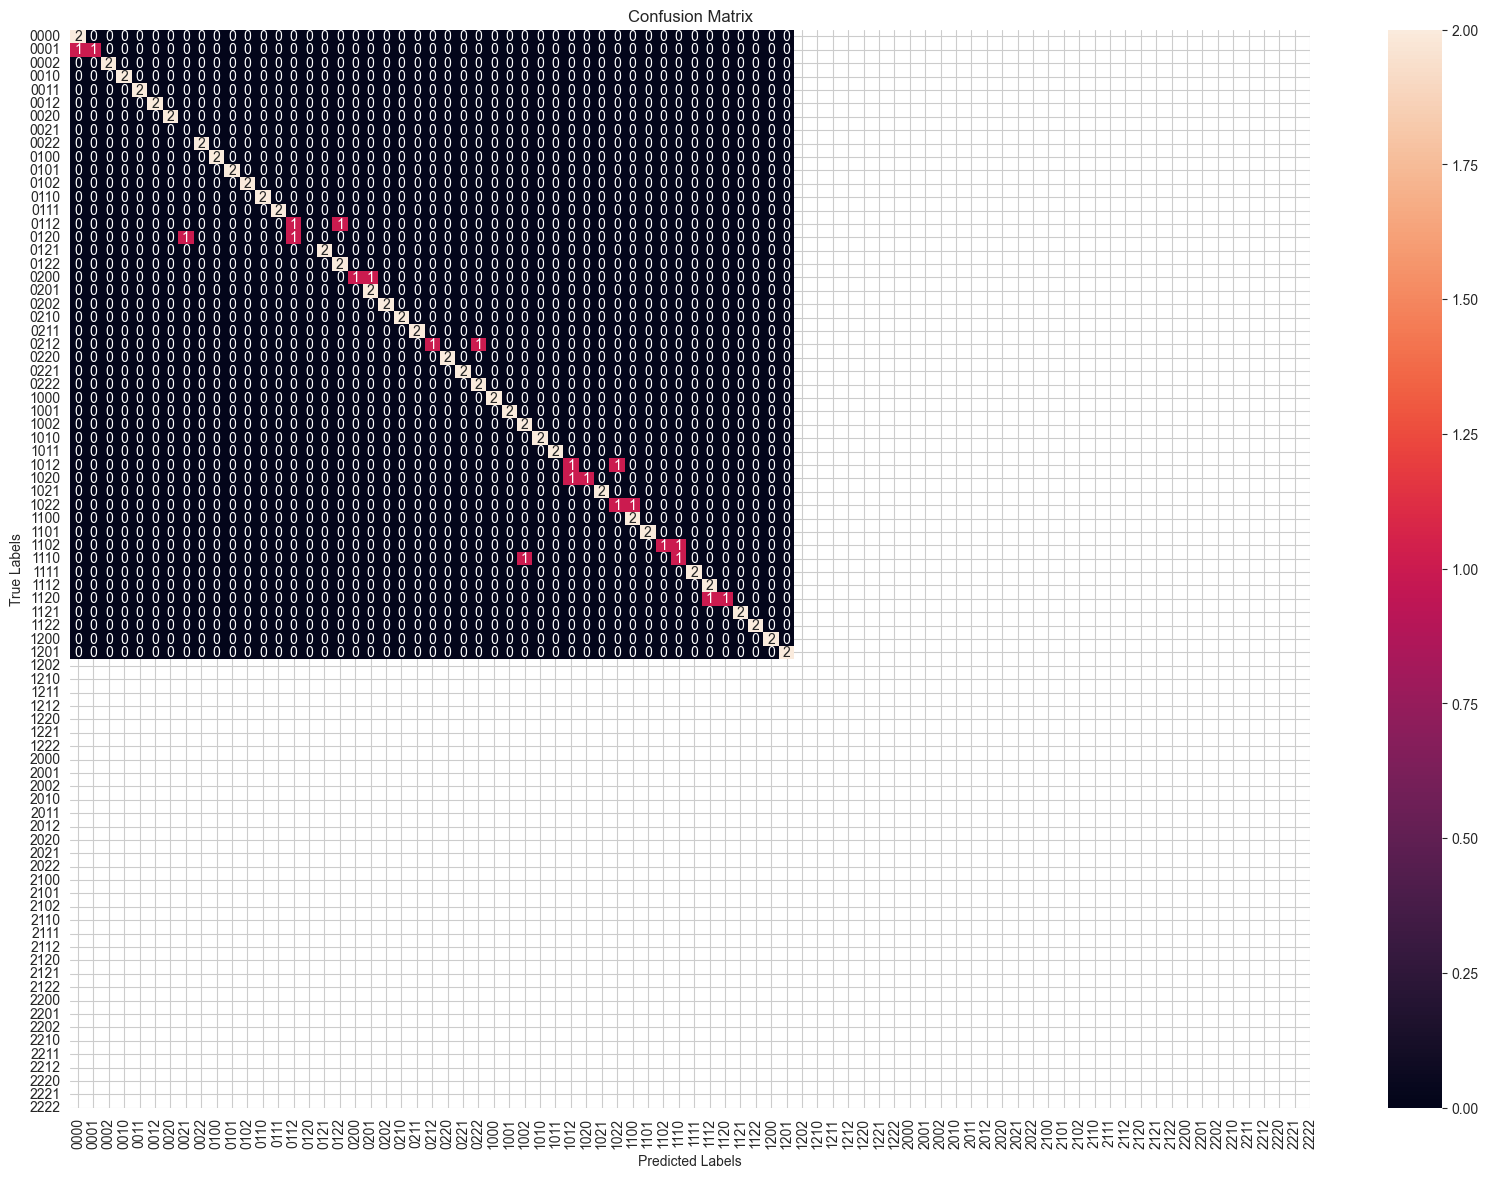

0.8695652173913043


In [107]:
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
# print(predicted_labels)
print(len(predicted_labels))
# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test_dots, 1)
print(len(true_class_labels))
# print(true_class_labels)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.9320652173913043
